In [36]:
city   = 'london'
infile = '../ProcessedData/' + city + '/venues_info/venues_time_series.dat'

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from scipy.stats import spearmanr
from collections import Counter

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 
    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())

def round_unix_date(dt_series, seconds=60, up=False):
    return dt_series // seconds * seconds + seconds * up


## GET THE AVG NORMALIZED TIME SERIES

In [3]:
def get_venues_times(infile, month = 1, length = 100):

    longest     = {}

    for ind, line in enumerate(open(infile)):
        fields = line.strip().split('\t')
        venue  = fields[0]
        times  = sorted([ round_unix_date(float(fff), month*30*24*60*60) for fff in fields[1:]])
        x, y = zip(* sorted([(k, v) for k, v in dict(Counter(times)).items()], key=lambda tup: tup[0]))       
        if len(x) > length:
              longest[venue] = (x,y)

    return longest
    
    
    
def get_avg_counts(infile, month):

    times_count = {}
    for ind, line in enumerate(open(infile)):
        times  = [ round_unix_date(float(fff), month*30*24*60*60) for fff in line.strip().split('\t')[1:]]
        for time in times:
            if time not in times_count:
                times_count[time] = 1
            else:
                times_count[time] += 1   

    return times_count    



def completing_timeseries(timeseriesdict, all_times):
    
    timeseriesdict_out = {}
    
    for ind, (ven, (time, cnt)) in enumerate(timeseriesdict.items()):

        mint   =  min(time)
        time_x =  []
        cnt_x  =  []

        for ind, t in enumerate(all_times):
            if t > mint:
                if t in time:
                    time_x.append(t)
                    cnt_x.append(cnt[time.index(t)])
                else:
                    time_x.append(t)
                    cnt_x.append(0)

        x, y = zip(* sorted([(k, v) for k, v in zip(time_x, cnt_x)], key=lambda tup: tup[0]))       
    
        timeseriesdict_out[ven] = (x,y)      

    return timeseriesdict_out



def normalize_time_series(timeseries, timeseries_avg, total_avg):   
    
    venues_times_norm = {}

    for ind, (ven, (times, cnts)) in enumerate(timeseries.items()):
        
        tt = []
        cc = []
        
        for i in range(len(times)):
            normcnt  = float(cnts[i]) / timeseries_avg[times[i]] * total_avg
            tt.append(times[i])
            cc.append(normcnt)
            
        venues_times_norm[ven] = (tt, cc)


    venues_times_norm_norm = {}
    for ind, (ven, (times, cnt)) in enumerate(venues_times_norm.items()):
        maxcnt = np.mean(cnt)
        cnt    = [cc/maxcnt for cc in cnt] 
        venues_times_norm_norm[ven] = (times, cnt)

            
    return venues_times_norm_norm




def viz_timeseries(timeseries, ttitle):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        if ind == 1000: break
        time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
        ax.plot(time_, cnt_, '-', linewidth = 0.1225)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()

In [4]:
longest_1m_12           = get_venues_times(infile, month = 6, length = 6)
avg_times_count_1m_12   = get_avg_counts(infile, month = 6)
total_avg               = np.mean(avg_times_count_1m_12.values())
all_times               = sorted(avg_times_count_1m_12.keys())
longest_1m_12_norm      = normalize_time_series(longest_1m_12, avg_times_count_1m_12, total_avg)
longest_1m_12_full      = completing_timeseries(longest_1m_12, all_times)
longest_1m_12_full_norm = normalize_time_series(longest_1m_12_full, avg_times_count_1m_12, total_avg)



In [30]:
len(longest_1m_12)

10189

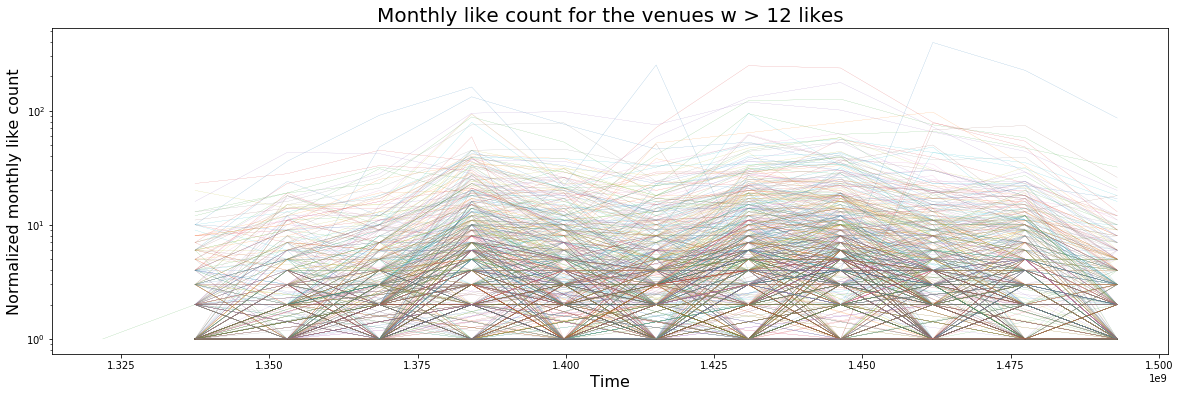

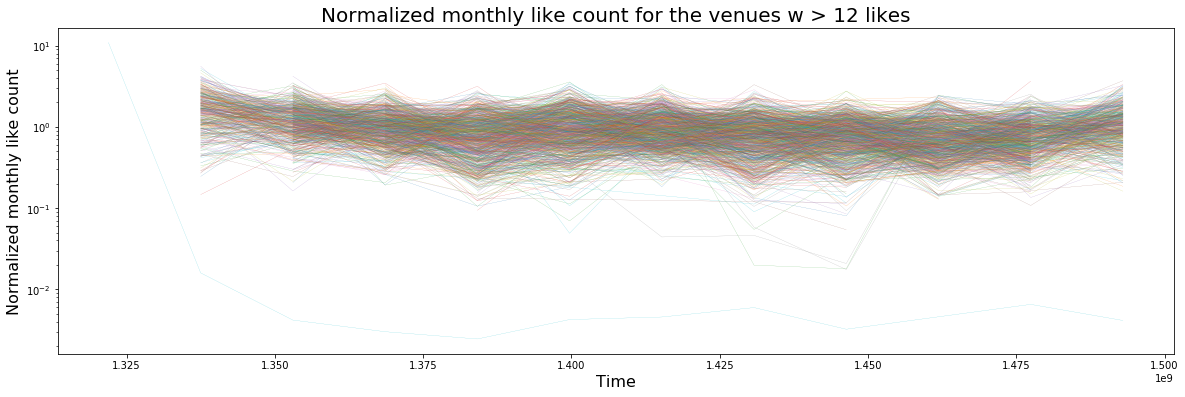

In [5]:
viz_timeseries(longest_1m_12, 'Monthly like count for the venues w > 12 likes')
viz_timeseries(longest_1m_12_norm, 'Normalized monthly like count for the venues w > 12 likes')

In [6]:
x = [5, 10, 20, 30, 40, 50, 70, 95, 100, 120]
y = []
for lng in [5, 10, 20, 30, 40, 50, 70, 95, 100, 120]:
    longest = get_venues_times(infile, length = lng)
    y.append(len(longest))    

Text(0.5,0,'Min length of time series')

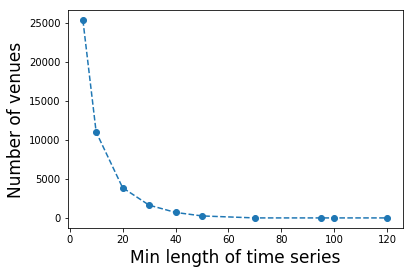

In [10]:
plt.plot(x, y, 'o--')
plt.ylabel('Number of venues', fontsize = 17)
plt.xlabel('Min length of time series', fontsize = 17)

## GROUP VENUES BASED ON AGE

In [7]:
# get the age of the venues
venues_age = {}
for ind, (venue, (time, count)) in enumerate(longest_1m_12.items()):
    venues_age[venue] = (max(time) - min(time) ) / (60*60*24*365)


Text(0.5,0,'Age of the venues')

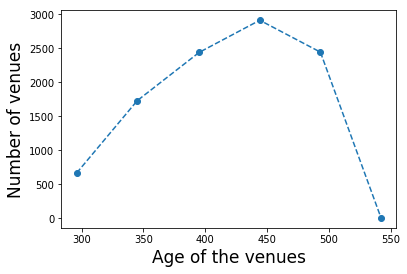

In [8]:
xx, yy = getDistribution( [round(100*v) for v in venues_age.values()], False)

plt.plot(xx, yy, 'o--')
plt.ylabel('Number of venues', fontsize = 17)
plt.xlabel('Age of the venues', fontsize = 17)

In [9]:
df_venues_ages = pd.DataFrame.from_dict(venues_age, orient='index')
df_venues_ages = df_venues_ages.rename(columns = {0 : 'age'})
df_venues_ages.index.name = 'venue'
df_venues_ages.head()

,age
venue,
4f649467e4b0dc7720150594,3.945205
4b043c50f964a520685222e3,4.438356
4b926c3af964a52068f833e3,4.931507
4ad7384bf964a520010921e3,4.931507
4e5fd59fb0fb754192cffc44,4.438356


In [41]:
df_venues_ages['quartile'] = pd.qcut(df_venues_ages['age'], 5, ['q1','q2','q3','q4', 'q5'])
Q1 = list(df_venues_ages[df_venues_ages['quartile'] == 'q1'].index)
Q2 = list(df_venues_ages[df_venues_ages['quartile'] == 'q2'].index)
Q3 = list(df_venues_ages[df_venues_ages['quartile'] == 'q3'].index)
Q4 = list(df_venues_ages[df_venues_ages['quartile'] == 'q4'].index)
Q5 = list(df_venues_ages[df_venues_ages['quartile'] == 'q5'].index)

Qs = [Q1, Q2, Q3, Q4, Q5]

okvenues = Q3 + Q4 + Q5
[v for k, v in venues_age.items() if k in okvenues]

[4.438356164383562,
 4.931506849315069,
 4.931506849315069,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.438356164383562,
 4.438356164383562,
 4.438356164383562,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.931506849315069,
 4.438356164383562,


Text(0.5,0,'Age of the venues')

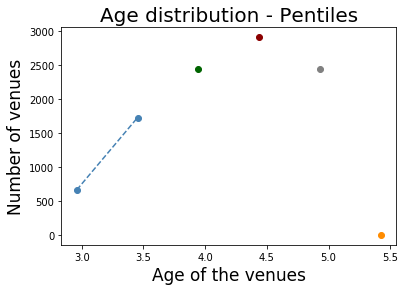

In [11]:
def get_x_y_age(venues_age, Q, c):

    xx   = [a for v, a in venues_age.items() if v in Q]
    x, y = getDistribution(xx, False)
    plt.plot(x, y, 'o--', color = c)
    
colors = ['steelblue', 'darkgreen', 'darkred', 'grey', 'darkorange']
    
for c, Q in zip(colors, Qs):
     get_x_y_age(venues_age, Q, c)

#get_x_y_age(venues_age, venues, 'r')        
        
        
plt.title('Age distribution - Pentiles', fontsize = 20)
plt.ylabel('Number of venues',  fontsize = 17)
plt.xlabel('Age of the venues', fontsize = 17)

10189 10189


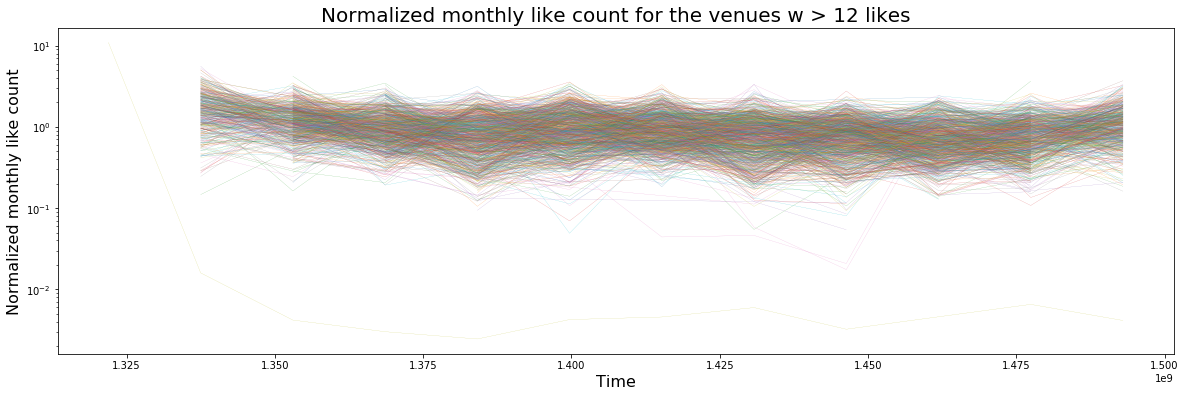

In [33]:
# filter the dictionaries

longest_1m_12_norm_Q3Q4 = {ven : data for ven, data in  longest_1m_12_norm.items() if ven in okvenues}    
    
print len(longest_1m_12_norm_Q3Q4), len(longest_1m_12_norm)    
viz_timeseries(longest_1m_12_norm_Q3Q4, 'Normalized monthly like count for the venues w > 12 likes')


# TIME-RESCALING TIMESEREs (~stretching)

In [14]:
def transform_ts(x, maxTT):

    minx = min(x)  
    x    = [xx - minx for xx in x] 
    maxx = max(x)
    x    = [xx * maxTT / maxx for xx in x]
    
    return x

maxTT = max(max(c[0]) for c in longest_1m_12.values())

In [34]:
longest_1m_12_norm_Q3Q4_stretched = {}

for ind, (venue, (time, count)) in enumerate(longest_1m_12_norm_Q3Q4.items()):
    longest_1m_12_norm_Q3Q4_stretched[venue] = (tuple(transform_ts(time, maxTT)), count) 

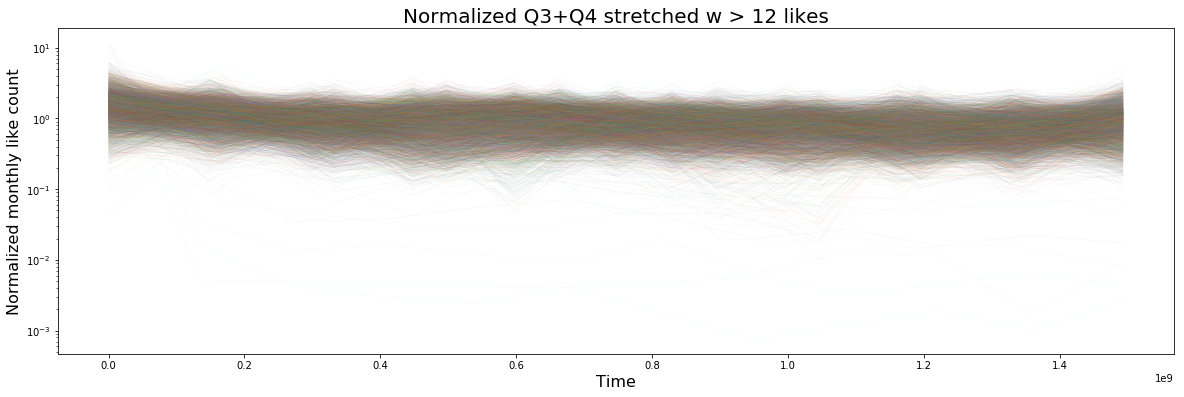

In [18]:

def viz_timeseries2(timeseries, ttitle):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        #if ind == 1000: break
        time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
        ax.plot(time_, cnt_, '-', linewidth = 0.05225, alpha = 0.5)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()


viz_timeseries2(longest_1m_12_norm_Q3Q4_stretched, 'Normalized Q3+Q4 stretched w > 12 likes')

# GET SIMILARITY MATRICES

In [23]:
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt
from numpy.linalg import norm
import random




In [24]:
def viz_timeseries3(timeseries, ttitle, venues):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        if ven in venues:
            time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
            ax.plot(time_, cnt_, '-', linewidth = 0.5225, alpha = 0.95)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()

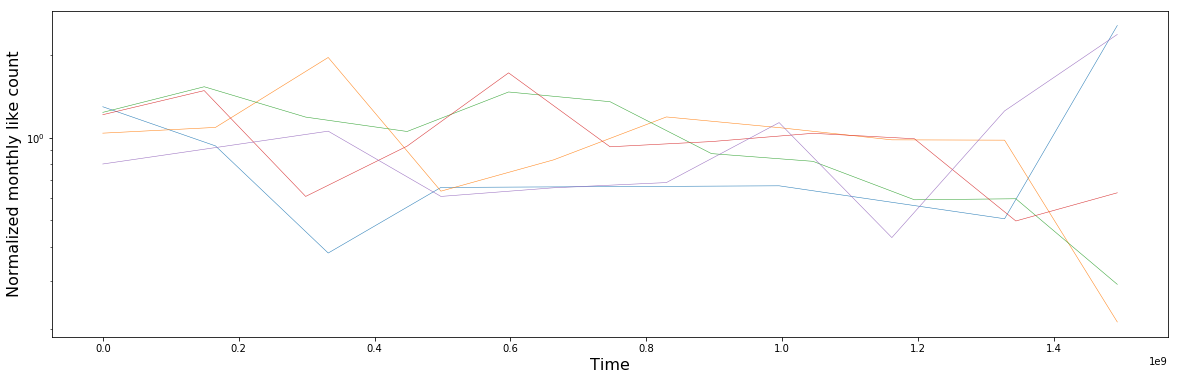

In [25]:
venues = ['4ac518f3f964a5209fae20e3', '51605f56e4b024efa71a9873', '4ac518cef964a520f8a520e3', '4bd0432a9854d13a6855f74d']
viz_timeseries3(longest_1m_12_norm_Q3Q4_stretched, '', random.sample(longest_1m_12_norm_Q3Q4_stretched.keys(), 5))

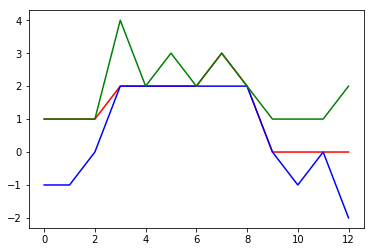

In [26]:
x = np.array([-2 + a for a in [1, 1, 2, 4, 2, 1, 2, 0]]).reshape(-1, 1)
y = np.array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0,0,0]).reshape(-1, 1)
z = np.array([ 1, 4, 2, 3, 2, 3, 2, 1,2]).reshape(-1, 1)



dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

map_x, map_y = path

plt.plot(y[map_y], 'r')


dist, cost, acc, path2 = dtw(x, z, dist=lambda x, z: norm(x - z, ord=1))
map_x2, map_z = path2



plt.plot(x[map_x2], 'b')





map_x


#plt.plot(x, 'r')
#plt.plot(y, 'b')
plt.plot(z[map_z], 'g')


In [27]:

tss = [np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[v])) for v in longest_1m_12_norm_Q3Q4_stretched.keys()[0:200]]
len(tss)


200

In [28]:
def getBinnedDistribution(x, y, nbins):

    n, bins = np.histogram(x, bins=nbins)
    sy, _   = np.histogram(x, bins=nbins, weights=y)
    mean    = sy/n

    return _, mean



<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


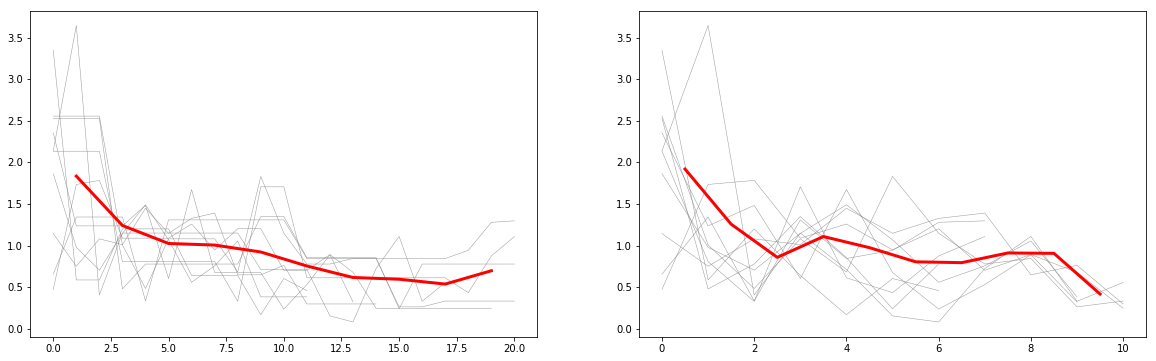

In [317]:
def avg_curve(a,b):
    
    return np.asarray([(a[i] + b[i])/2.0 for i in range(len(a))]).reshape(-1, 1)
        

f, ax = plt.subplots(1, 2, figsize=(20, 6))



x  = tss[0][1].reshape(-1, 1)
y  = tss[1][1].reshape(-1, 1)
dist, cost, acc, path   = dtw(x,  y, dist=lambda x, y: norm(x - y, ord=1))
map_x, map_y = path
xy = avg_curve(x[map_x].flatten(),y[map_y].flatten())

ax[0].plot(x[map_x], 'grey', linewidth = 0.5, alpha = 0.8)
ax[0].plot(y[map_y], 'grey', linewidth = 0.5, alpha = 0.8)

ax[1].plot(y,'grey', linewidth = 0.5, alpha = 0.8)
ax[1].plot(x,'grey', linewidth = 0.5, alpha = 0.8)

xallm = list(x[map_x].flatten()) + list(y[map_y].flatten())
tallm = range(len(map_x)) + range(len(map_y))
xall  = list(x.flatten()) + list(y.flatten())
tall  = range(len(x)) + range(len(y))

maxl  = range(len(x)) + range(len(y))


print 

for i in range(2,10):

    z  = tss[i][1].reshape(-1, 1)

    dist2, cost, acc, path2 = dtw(xy, z, dist=lambda x, z: norm(x - z, ord=1))
    map_xy, map_z = path2

    print type(map_xy)
    
    maxx = max([len(z[map_z]), len(xy[map_xy])])
    if maxx > maxl:
        maxl = maxx
    

    ax[0].plot(z[map_z],'grey', linewidth = 0.5, alpha = 0.8)
    ax[1].plot(z, 'grey', linewidth = 0.5, alpha = 0.8)
   
    xallm += list(z[map_z].flatten())
    xall  += list(z.flatten())
    tallm += range(len(map_z))
    tall  += range(len(z))

    xy = avg_curve(xy[map_xy].flatten(),z[map_z].flatten())

   
bx, by = getBinnedDistribution(tallm, xallm, 10)    
bx= (bx[1:] + bx[:-1])/2
ax[0].plot(bx, by, 'r', linewidth = 3)

bx, by = getBinnedDistribution(tall, xall, 10)    
bx= (bx[1:] + bx[:-1])/2
ax[1].plot(bx, by, 'r', linewidth = 3)

200


NameError: name 'xallm' is not defined

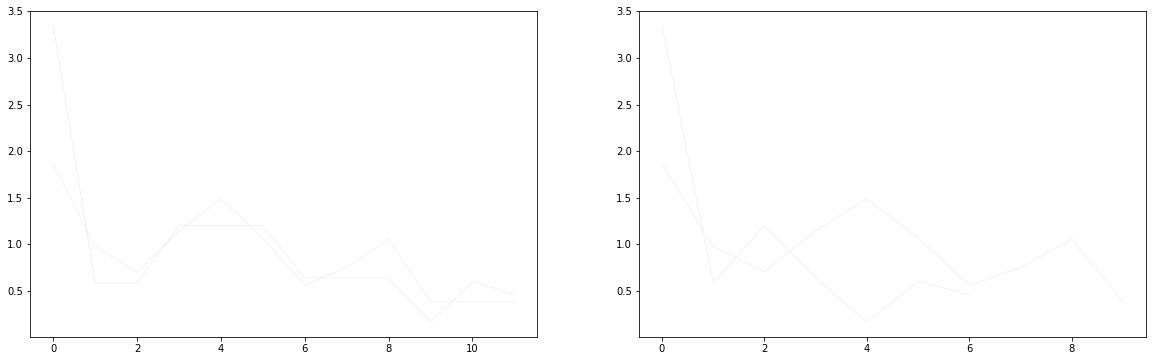

In [29]:
def avg_curve(a,b):
    
    return np.asarray([(a[i] + b[i])/2.0 for i in range(len(a))]).reshape(-1, 1)
        

f, ax = plt.subplots(1, 2, figsize=(20, 6))


x  = tss[0][1].reshape(-1, 1)

maxl = len(tss[0][1])


print len(tss)
for i in range(1,199):

    
    y  = tss[i][1].reshape(-1, 1)
    dist, cost, acc, path   = dtw(x,  y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path

    if len(tss[i][1]):
        maxl = len(tss[i][1])
    
  

    if i == 1:
        ax[0].plot(x[map_x],'grey', linewidth = 0.5, alpha = 0.2)
        ax[1].plot(x, 'grey', linewidth = 0.5, alpha = 0.2)
    
    ax[0].plot(y[map_y],'grey', linewidth = 0.5, alpha = 0.2)
    ax[1].plot(y, 'grey', linewidth = 0.5, alpha = 0.2)
   
    xallm += list(y[map_y].flatten())
    xall  += list(y.flatten())
    tallm += range(len(map_y))
    tall  += range(len(y))
    

   
bx, by = getBinnedDistribution(tallm, xallm, 10)    
bx= (bx[1:] + bx[:-1])/2
ax[0].plot(bx, by, 'r', linewidth = 3)

bx, by = getBinnedDistribution(tall, xall, 10)    
bx= (bx[1:] + bx[:-1])/2
ax[1].plot(bx, by, 'r', linewidth = 3)


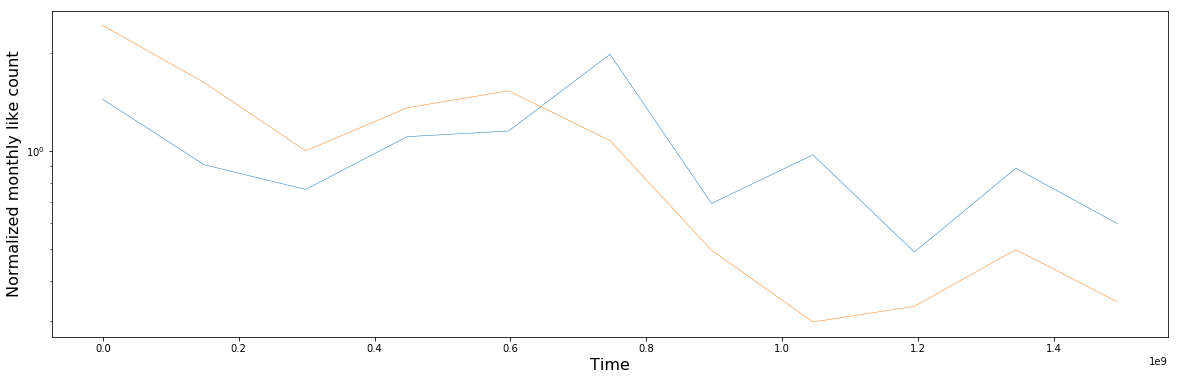

In [43]:

viz_timeseries3(longest_1m_12_norm_Q3Q4_stretched, '', ['4ac518baf964a52006a220e3', '4acd9febf964a52069cc20e3'])

4463


(array([3.356e+03, 0.000e+00, 2.370e+03, 0.000e+00, 1.867e+03, 0.000e+00,
        1.409e+03, 0.000e+00, 1.185e+03, 2.000e+00]),
 array([ 7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ]),
 <a list of 10 Patch objects>)

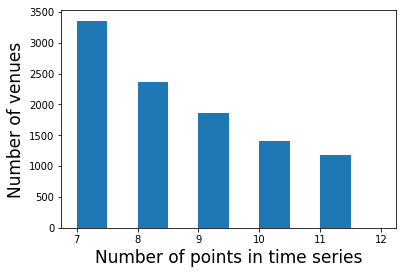

In [35]:
length_distr = {}

v_60 = []
for v , (c,t) in longest_1m_12_norm_Q3Q4_stretched.items():
    
    lng = len(c)
    #if lng not in length_distr:
    #    length_distr[lng] = 1
    #else:
    length_distr[v] = lng
    
    
    if len(c) > 8:
        v_60.append( v )

print len(v_60)
plt.ylabel('Number of venues',               fontsize = 17)
plt.xlabel('Number of points in time series', fontsize = 17)
plt.hist(length_distr.values())        

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdee53f0050>,
       dtype=object))

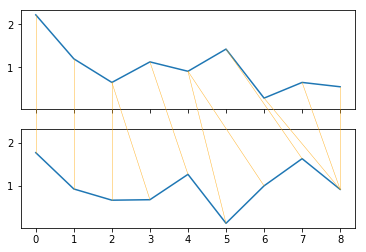

In [66]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
import random 
#s2 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[random.sample(v_60,1)
s1 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[ random.sample(v_60,1)[0] ][1])).reshape(-1, 1)
s2 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[ random.sample(v_60,1)[0] ][1])).reshape(-1, 1)


path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

#fout = open('TIMESERIES_911.DAT', 'w')
#for v in v_60:
#    fout.write( '\t'.join([str(fff) for fff in list(longest_1m_12_norm_Q3Q4_stretched[ random.sample(v_60,1)[0] ][1])])+ '\n')
#fout.close()

11 16


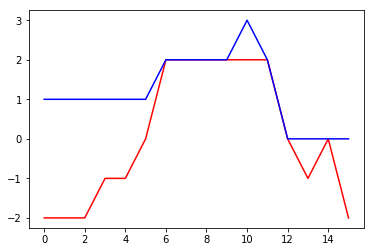

In [170]:
x = np.array([-2 + a for a in [0,0, 0, 1, 1, 2, 4, 2, 1, 2, 0]]).reshape(-1, 1)
y = np.array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0,0,0]).reshape(-1, 1)

x0 = range(len([1, 1, 1, 2, 2, 2, 2, 3, 2, 0]))
x1 = [aa - 1.178 for aa in range(len([1, 1, 1, 2, 2, 2, 2, 3, 2, 0]))]


dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

map_x, map_y = path

plt.plot(x[map_x], 'r')
plt.plot(y[map_y], 'b')

print len(x), len(map_x)
#plt.plot(x)
#plt.plot(y)


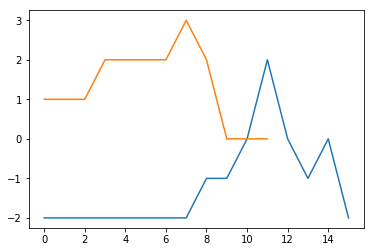

In [137]:
plt.plot(x)
plt.plot(y)

[(0, 0), (1, 0), (2, 0), (3, 1), (4, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (6, 9), (7, 9), (8, 9), (9, 9)]


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdee47be590>,
       dtype=object))

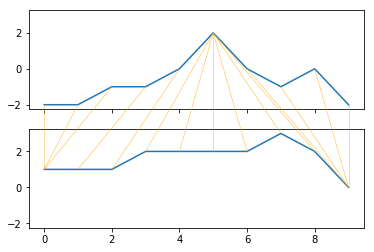

In [93]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
path = dtw.warping_path(x, y)
print path
dtwvis.plot_warping(x, y, path, filename="warp.png")